<a href="https://colab.research.google.com/gist/stnava/061b2cb8f79c582822e539f238809bd8/xray_sr_randpatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
#!/usr/bin/python3
import os.path
from os import path
# !pip uninstall antspyx
!pip install antspyx
!pip install git+https://github.com/ANTsX/ANTsPyNet
import ants

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ANTsX/ANTsPyNet to /tmp/pip-req-build-09f6ffgk
  Running command git clone -q https://github.com/ANTsX/ANTsPyNet /tmp/pip-req-build-09f6ffgk


In [66]:
import ants

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**overview**<br>
<br>
we are reviewing a simple script for training a super-resolution network<br>
that uses a straightforward approach and does not require a discriminator<br>
network which is, generally speaking, much harder to optimize/control.<br>
instead, we rely on total variation and perceptual losses in addition to<br>
the standard reconstruction loss ( mean squared error ).  while this is<br>
done in TF, it could be implemented transparently in pytorch or whatever.<br>
the implementation will also work in 3D if weight transfer is done as<br>
explained [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7279929/).

**goals**<br>
provide a conceptual and practical foundation for how to train a super-Resolution<br>
network.  ideally, we can collectively identify a better network, parameter set,<br>
evaluation criterion, perceptual loss or other feature that would improve<br>
on what we have now.  the hyperplane and DGX resources support such efforts.

**glossary**<br>
<br>
[*super-resolution*](https://scholar.google.com/scholar?q=super-resolution+image&hl=en&as_sdt=0%2C30&as_ylo=1965&as_yhi=1977): a typically nonlinear approach to upsampling data in order<br>
to increase the effective or perceived image resolution.<br>
<br>
*deep backprojection network (DBPN)*: Haris et al Deep Back-Projection Networks For Super-Resolution<br>
a residual network that does both up and downsampling and uses perceptual losses.<br>
the number of backprojection layers relates to how many residual layers exist.<br>
[references here](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C30&q=haris+deep+back+projection+network&btnG=)<br>
<br>
*perceptual loss*: - a loss function that maps raw image features to a<br>
higher-dimensional feature space defined by a pre-trained network<br>
[references](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C30&q=perceptual+losses+super+resolution&btnG=&oq=perceptual+losses+super)

**input parameters**<br>
<br>
user defined parameters below - they include options for perceptual features<br>
the number of back-projection layers, patch scaling options and weighting<br>
terms for the loss function

In [68]:
import sys
arglist = (sys.argv)
print( arglist )
arglist=["name",5,"True",0.5,256,"True","True"]
nbp=int( arglist[1] )
do22=(arglist[2] == "True" ) | (arglist[2] == 1 )
featureWeight = 200.0
ctmod = 10
mybs  = 1028
patch_scale = True
if do22 == 1:
    featureWeight = 0.25

['/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-d3c370d3-5046-42b7-a6b9-9c095ccda3d8.json']


**Note**: loss function weights are important for performance and are typically<br>
set empirically or by parameter search where quality is assessed against an independent metric

In [69]:
if len( arglist ) > 3:
    featureWeight = float( arglist[3] )
    print( "featureWeight" + str( featureWeight) )
if len( arglist ) > 4:
    ctmod = int( arglist[4] )
if len( arglist ) > 5:
    patch_scale = arglist[5] == "True"

featureWeight0.5


set up naming such that we know something about the stored network

In [70]:
ofn = "dbpnn-nbp" + str(nbp) + '-ctmod' + str(ctmod) + "-patchscale" + str(patch_scale) +  "-vggfeat54.h5"
if do22:
    ofn = "dbpnn-nbp" + str(nbp) + '-ctmod' + str(ctmod) +"-patchscale" + str(patch_scale) +  "-vggfeat22_p3eq.h5"
print( "network config: " + ofn, flush=True )
print( "weight: " + str( featureWeight ), flush=True  )

network config: dbpnn-nbp5-ctmod256-patchscaleTrue-vggfeat22_p3eq.h5
weight: 0.5


standard imports for I/O, sampling and image manipulation

In [71]:
import ants
import antspynet
import random
import glob as glob
import numpy as np
import tensorflow as tf
import ants
import tensorflow.keras as keras
featureWeight = tf.constant( featureWeight )

**dependencies**<br>
1. tensorflow 2.0 or higher<br>
2. [ANTsPy](https://github.com/ANTsX/ANTsPy)<br>
3. [ANTsPyNet](https://github.com/ANTsX/ANTsPyNet)

we use freely available data for reference - one can get started with just<br>
one of the tar.gz files - these should be unzipped and will result in a folder<br>
called "images/" with a bunch of jpgs in it<br>
get data from here https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/37178474737

import the VGG19 network with pre-trained weights

In [72]:
from tensorflow.keras.applications.vgg19 import VGG19
# our VGG19 assumes data is centered about 0 with a range of 255 the
# offset intensity controls this where range is offsetIntensity*2
offsetIntensity = 127.5

load in relevant objects from keras so we can build our network

In [73]:
from keras.models import Model
from keras.layers import (Input, Add, Subtract,
                          PReLU, Concatenate,
                          UpSampling2D, UpSampling3D,
                          Conv2D, Conv2DTranspose,
                          Conv3D, Conv3DTranspose)

define the DBPN network - this uses a model definition that is general to<br>
both 2D and 3D. recommended parameters for different upsampling rates can<br>
be found in the papers by Haris et al.  We make one significant change to<br>
the original architecture by allowing standard interpolation for upsampling<br>
instead of convolutional upsampling.  this is controlled by the interpolation<br>
option.

In [74]:
def dbpn(input_image_size,
                                                 number_of_outputs=1,
                                                 number_of_base_filters=64,
                                                 number_of_feature_filters=256,
                                                 number_of_back_projection_stages=7,
                                                 convolution_kernel_size=(12, 12),
                                                 strides=(8, 8),
                                                 last_convolution=(3, 3),
                                                 number_of_loss_functions=1,
                                                 interpolation = 'nearest'
                                                ):
    idim = len( input_image_size ) - 1
    if idim == 2:
        myconv = Conv2D
        myconv_transpose = Conv2DTranspose
        myupsampling = UpSampling2D
        shax = ( 1, 2 )
        firstConv = (3,3)
        firstStrides=(1,1)
        smashConv=(1,1)
    if idim == 3:
        myconv = Conv3D
        myconv_transpose = Conv3DTranspose
        myupsampling = UpSampling3D
        shax = ( 1, 2, 3 )
        firstConv = (3,3,3)
        firstStrides=(1,1,1)
        smashConv=(1,1,1)
    def up_block_2d(L, number_of_filters=64, kernel_size=(12, 12), strides=(8, 8),
                    include_dense_convolution_layer=True):
        if include_dense_convolution_layer == True:
            L = myconv(filters = number_of_filters,
                       use_bias=True,
                       kernel_size=smashConv,
                       strides=firstStrides,
                       padding='same')(L)
            L = PReLU(alpha_initializer='zero',
                      shared_axes=shax)(L)
        # Scale up
        if idim == 2:
            H0 = myupsampling( size = strides, interpolation=interpolation )(L)
        if idim == 3:
            H0 = myupsampling( size = strides )(L)
        H0 = myconv(filters=number_of_filters,
                    kernel_size=firstConv,
                    strides=firstStrides,
                    use_bias=True,
                    padding='same')(H0)
        H0 = PReLU(alpha_initializer='zero',
                   shared_axes=shax)(H0)
        # Scale down
        L0 = myconv(filters=number_of_filters,
                    kernel_size=kernel_size,
                    strides=strides,
                    kernel_initializer='glorot_uniform',
                    padding='same')(H0)
        L0 = PReLU(alpha_initializer='zero',
                   shared_axes=shax)(L0)
        # Residual
        E = Subtract()([L0, L])
        # Scale residual up
        if idim == 2:
            H1 = myupsampling( size = strides, interpolation=interpolation  )(E)
        if idim == 3:
            H1 = myupsampling( size = strides )(E)
        H1 = myconv(filters=number_of_filters,
                    kernel_size=firstConv,
                    strides=firstStrides,
                    use_bias=True,
                    padding='same')(H1)
        H1 = PReLU(alpha_initializer='zero',
                   shared_axes=shax)(H1)
        # Output feature map
        up_block = Add()([H0, H1])
        return up_block
    def down_block_2d(H, number_of_filters=64, kernel_size=(12, 12), strides=(8, 8),
                    include_dense_convolution_layer=True):
        if include_dense_convolution_layer == True:
            H = myconv(filters = number_of_filters,
                       use_bias=True,
                       kernel_size=smashConv,
                       strides=firstStrides,
                       padding='same')(H)
            H = PReLU(alpha_initializer='zero',
                      shared_axes=shax)(H)
        # Scale down
        L0 = myconv(filters=number_of_filters,
                    kernel_size=kernel_size,
                    strides=strides,
                    kernel_initializer='glorot_uniform',
                    padding='same')(H)
        L0 = PReLU(alpha_initializer='zero',
                   shared_axes=shax)(L0)
        # Scale up
        if idim == 2:
            H0 = myupsampling( size = strides, interpolation=interpolation )(L0)
        if idim == 3:
            H0 = myupsampling( size = strides )(L0)
        H0 = myconv(filters=number_of_filters,
                    kernel_size=firstConv,
                    strides=firstStrides,
                    use_bias=True,
                    padding='same')(H0)
        H0 = PReLU(alpha_initializer='zero',
                   shared_axes=shax)(H0)
        # Residual
        E = Subtract()([H0, H])
        # Scale residual down
        L1 = myconv(filters=number_of_filters,
                    kernel_size=kernel_size,
                    strides=strides,
                    kernel_initializer='glorot_uniform',
                    padding='same')(E)
        L1 = PReLU(alpha_initializer='zero',
                   shared_axes=shax)(L1)
        # Output feature map
        down_block = Add()([L0, L1])
        return down_block
    inputs = Input(shape=input_image_size)
    # Initial feature extraction
    model = myconv(filters=number_of_feature_filters,
                   kernel_size=firstConv,
                   strides=firstStrides,
                   padding='same',
                   kernel_initializer='glorot_uniform')(inputs)
    model = PReLU(alpha_initializer='zero',
                  shared_axes=shax)(model)
    # Feature smashing
    model = myconv(filters=number_of_base_filters,
                   kernel_size=smashConv,
                   strides=firstStrides,
                   padding='same',
                   kernel_initializer='glorot_uniform')(model)
    model = PReLU(alpha_initializer='zero',
                  shared_axes=shax)(model)
    # Back projection
    up_projection_blocks = []
    down_projection_blocks = []
    model = up_block_2d(model, number_of_filters=number_of_base_filters,
      kernel_size=convolution_kernel_size, strides=strides)
    up_projection_blocks.append(model)
    for i in range(number_of_back_projection_stages):
        if i == 0:
            model = down_block_2d(model, number_of_filters=number_of_base_filters,
              kernel_size=convolution_kernel_size, strides=strides)
            down_projection_blocks.append(model)
            model = up_block_2d(model, number_of_filters=number_of_base_filters,
              kernel_size=convolution_kernel_size, strides=strides)
            up_projection_blocks.append(model)
            model = Concatenate()(up_projection_blocks)
        else:
            model = down_block_2d(model, number_of_filters=number_of_base_filters,
              kernel_size=convolution_kernel_size, strides=strides,
              include_dense_convolution_layer=True)
            down_projection_blocks.append(model)
            model = Concatenate()(down_projection_blocks)
            model = up_block_2d(model, number_of_filters=number_of_base_filters,
              kernel_size=convolution_kernel_size, strides=strides,
              include_dense_convolution_layer=True)
            up_projection_blocks.append(model)
            model = Concatenate()(up_projection_blocks)
    outputs = myconv(filters=number_of_outputs,
                     kernel_size=last_convolution,
                     strides=firstStrides,
                     padding = 'same',
                     kernel_initializer = "glorot_uniform")(model)
    if number_of_loss_functions == 1:
        deep_back_projection_network_model = Model(inputs=inputs, outputs=outputs)
    else:
        outputList=[]
        for k in range(number_of_loss_functions):
            outputList.append(outputs)
        deep_back_projection_network_model = Model(inputs=inputs, outputs=outputList)
    return deep_back_projection_network_model

will build testing data on the fly

In [75]:
do_test = True

set up strides and patch sizes - **these could also be explored empirically**

In [76]:
st = 96
psz = 32
# we are doing 2x SR so low-res size is just 48
lsz = int(psz/2)

generate a random corner index for a patch

In [77]:
def get_random_base_ind( full_dims=(1024,1024), off = 10, patchWidth = 96 ):
    baseInd = [None,None]
    for k in range(2):
        baseInd[k]=random.sample( range( off, full_dims[k]-1-patchWidth ), 1 )[0]
    return baseInd

extract a random patch

In [90]:
def get_random_patch( img, patchWidth=psz ):
    mystd = 0
    while mystd == 0:
        inds = get_random_base_ind()
        hinds = [None,None]
        for k in range(len(inds)):
            hinds[k] = inds[k] + patchWidth
        myimg = ants.crop_indices( img, inds, hinds )
        mystd = myimg.std()
    return myimg

def get_random_patch_pair( img, img2, patchWidth=psz ):
    mystd = 0
    while mystd == 0:
        inds = get_random_base_ind()
        hinds = [None,None]
        for k in range(len(inds)):
            hinds[k] = inds[k] + patchWidth
        myimg = ants.crop_indices( img, inds, hinds )
        myimg2 = ants.crop_indices( img2, inds, hinds )
        mystd = myimg.std()
    return myimg, myimg2


set up vgg features

In [79]:
myvgg = VGG19(include_top=False, weights='imagenet',
  input_shape=(psz,psz,3), pooling=None, classes=1000)
# perceptual features - one can explore different layers and features
# these layers - or combinations of these - are commonly used in the literature
# as feature spaces for loss functions.  weighting terms relative to MSE are
# also given in several papers which can help guide parameter setting.
# **VGG54**
myfeatmodel54 = tf.keras.Model( inputs=myvgg.inputs, outputs=myvgg.layers[20].output )
# **VGG22**
myfeatmodel22 = tf.keras.Model( inputs=myvgg.inputs, outputs=myvgg.layers[5].output )

**loss term**<br>
set up custom loss function with msq and vgg22 features - i have set the<br>
parameters here manually to defaults that produced interesting results.<br>
not making a claim that these are better or worse than other parameter sets.<br>
VGG22 is shallow and fast to compute.<br>
the loss function is a sum over:<br>
1. mean squared intensity difference<br>
2. VGG feature norms<br>
3. an experimental neural QC-metric<br>
4. an experimental neural QC-metric<br>
5. the total variation loss

In [80]:
def my_loss_22(y_true, y_pred,
  msqwt = tf.constant( 0.5 ),
  qcWeight = tf.constant([50.0,5.0]),
  fw=tf.constant(0.02),
  tvwt = tf.constant( 1.0e-4 ) ):
    squared_difference = tf.square(y_true - y_pred)
    myax = [1,2,3]
    msqTerm = tf.reduce_mean(squared_difference, axis=myax)
    temp1 = myfeatmodel22(y_true)
    temp2 = myfeatmodel22(y_pred)
    vggsquared_difference = tf.square(temp1-temp2)
    vggTerm = tf.reduce_mean(vggsquared_difference, axis=myax)
    # an additional two-term loss based on NIMA
#    qcTerm = tf.reduce_mean( tf.square( qcmodel( y_pred/127.5 ) - qcmodel( y_true/127.5 ) ), axis=[1]  )
#    qcTerm = qcTerm[0] * qcWeight[0] + qcTerm[1] * qcWeight[1]
    tvTerm = tf.reduce_mean( tf.image.total_variation( y_pred ) ) * tvwt
#    return ( msqTerm * msqwt + vggTerm * fw + qcTerm + tvTerm )
    return ( msqTerm * msqwt + vggTerm * fw + tvTerm )

not used here - VGG54 is costlier b/c it's fairly deep in the VGG19 network

In [81]:
def my_loss_54(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    myax = [1,2,3]
    msqTerm = tf.reduce_mean(squared_difference, axis=myax)
    temp1 = myfeatmodel54(y_true)
    temp2 = myfeatmodel54(y_pred)
    vggsquared_difference = tf.square(temp1-temp2)
    vggTerm = tf.reduce_mean(vggsquared_difference, axis=myax)
    return ( msqTerm + vggTerm * featureWeight )

**model instantiation**: these are close to defaults for the 2x network.<br>
empirical evidence suggests that making covolutions and strides evenly<br>
divisible by each other reduces artifacts.  2*3=6.

In [82]:
mdl = dbpn( (None,None,3),
  number_of_outputs=3,
  number_of_base_filters=64,
  number_of_feature_filters=256,
  number_of_back_projection_stages=nbp,
  convolution_kernel_size=(6, 6),
  strides=(1, 1),
  last_convolution=(3, 3), number_of_loss_functions=1, interpolation='nearest')

collect all the images you have locally

In [83]:
print("assemble images", flush=True )
imgfns = glob.glob( "/content/drive/MyDrive/xray_images/*png")
random.shuffle(imgfns)
# 90\% training data
n = round( len( imgfns ) * 0.7 )
imgfnsTrain = imgfns[0:n]      # just start small
imgfnsTest = imgfns[(n+1):len(imgfns)]    # just a few test for now
# get a reference image from the sample - we assume all are the same size
# here which is true in this case.  small changes would be needed for
# generalization.
img = ants.image_read( imgfnsTrain[0] )
print( imgfns )

assemble images
['/content/drive/MyDrive/xray_images/00006585_008.png', '/content/drive/MyDrive/xray_images/00006585_010.png', '/content/drive/MyDrive/xray_images/00006585_013.png', '/content/drive/MyDrive/xray_images/00006585_017.png', '/content/drive/MyDrive/xray_images/00006585_009.png', '/content/drive/MyDrive/xray_images/00006585_014.png', '/content/drive/MyDrive/xray_images/00006585_011.png', '/content/drive/MyDrive/xray_images/00006585_007.png', '/content/drive/MyDrive/xray_images/00006585_012.png', '/content/drive/MyDrive/xray_images/00006585_015.png', '/content/drive/MyDrive/xray_images/00006586_000.png', '/content/drive/MyDrive/xray_images/00006585_016.png']


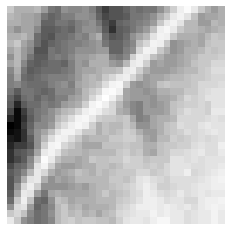

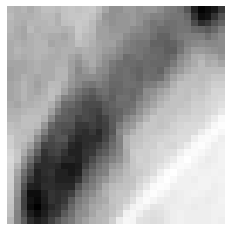

In [91]:
img = ants.image_read( imgfnsTrain[0] )
img2 = ants.image_read( imgfnsTrain[1] )
patch1, patch2 = get_random_patch_pair( img, img2 )
ants.plot(patch1)
ants.plot(patch2)

get pre-trained network weights

In [92]:
ofn='/content/drive/MyDrive/dbpnn-nbp5-ctmod4-patchscaleTrue-vggfeat22_p3eq.h5'
print( os.path.isfile(ofn) )
print( ofn )
if os.path.isfile(ofn):
    print( "load " + ofn )
    mdl = tf.keras.models.load_model( ofn, compile=False )

False
/content/drive/MyDrive/dbpnn-nbp5-ctmod4-patchscaleTrue-vggfeat22_p3eq.h5


this is the experimental QC network - you may not have this in which case<br>
you would comment this code out and in the loss function as well - results<br>
will remain fairly similar.

qcmodelfn = "resnet_koniq10k_QC_ThreeChan_MS_HR_patch_GlobalScaleMAE512x512.h5"<br>
qcmodel = tf.keras.models.load_model( qcmodelfn, compile=False )

set an optimizer - just standard Adam - may be sensitive to learning_rate

In [86]:
ct = 0
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

model compilation

In [87]:
if do22:
    mdl.compile(optimizer=opt, loss=my_loss_22)
else:
    mdl.compile(optimizer=opt, loss=my_loss_54)

resampling - use a custom antspynet layer for this (also in antsrnet)<br>
key here is that these networks dont need to know the input spatial<br>
dimensions in order to work effectively.  this is also a very tricky<br>
part of TF: the coordinate system for resampling is different than, for<br>
example, ITK.  not sure this is well-documented but it means that mixing<br>
resampling done by TF and by ITK will not provide the same results and this<br>
will impact training, inference, evaluation, etc.

In [88]:
myinput = tf.keras.layers.Input( [None,None,3] )
mytarget = tf.keras.layers.Input( [None,None,3] )
output = antspynet.ResampleTensorToTargetTensorLayer2D('linear')([myinput, mytarget])
rmodel = tf.keras.Model(inputs=[myinput, mytarget], outputs=output)
outputnn = antspynet.ResampleTensorToTargetTensorLayer2D('nearest_neighbor')([myinput, mytarget])
rmodelnn = tf.keras.Model(inputs=[myinput, mytarget], outputs=outputnn)

build some test data - high res, low res and bilinear

In [93]:
if do_test:
    mybs = 2 # FIXME may want to increase this for real training runs
    patchesOrigTe = np.zeros(shape=(mybs,psz,psz,3))
    patchesResamTe = np.zeros(shape=(mybs,psz,psz,3))
    for myb in range(mybs):
      imgfn = random.sample( imgfnsTest, 1 )[0]
      img = ants.image_read( imgfn )
      img = img - img.min()
      img = img / img.max() * offsetIntensity*2.0 - offsetIntensity # for VGG
      if img.components > 1:
        img = ants.split_channels(img)[0]
      rRotGenerator = ants.contrib.RandomRotate2D( ( 0, 50 ), reference=img )
      tx0 = rRotGenerator.transform()
      tx0inv = ants.invert_ants_transform(tx0)
      rimg = tx0.apply_to_image( img )
      rimg = tx0inv.apply_to_image( rimg )
      img, rimg = get_random_patch_pair( img, rimg )
      if patch_scale:
        img = img - img.min()
        rimg = rimg - rimg.min()
      if img.max() > 0 and rimg.max() > 0 :
        img = img / img.max() * offsetIntensity*2.0 - offsetIntensity # for VGG
        rimg = rimg / rimg.max() * offsetIntensity*2.0 - offsetIntensity # for VGG
      for k in range(3):
        patchesOrigTe[myb,:,:,k] = img.numpy()
        patchesResamTe[myb,:,:,k] = rimg.numpy()
      patchesOrigTeTf = tf.cast( patchesOrigTe, "float32")
      patchesResamTeTf = tf.cast( patchesResamTe, "float32")


**data generation**<br>
recent versions of tensorflow/keras allow data generators to be passed<br>
directly to the fit function.  underneath, this does a fairly efficient split<br>
between GPU and CPU usage and data transfer.  EG probably knows more about this.<br>
this generator randomly chooses between linear and nearest neighbor downsampling.<br>
the *patch_scale* option can also be seen here which impacts how the network<br>
sees/learns from image intensity.

In [94]:
def my_generator( mybs , ntimesbatch = 16 ):
    while True:
        for myn in range(ntimesbatch):
            patchesOrig = np.zeros(shape=(mybs,psz,psz,3))
            patchesResam = np.zeros(shape=(mybs,psz,psz,3))
            for myb in range(mybs):
                imgfn = random.sample( imgfnsTrain, 1 )[0]
                img = ants.image_read( imgfn )
                img = img - img.min()
                img = img / img.max() * offsetIntensity*2.0 - offsetIntensity # for VGG
                if img.components > 1:
                    img = ants.split_channels(img)[0]
                rRotGenerator = ants.contrib.RandomRotate2D( ( 0, 50 ), reference=img )
                tx0 = rRotGenerator.transform()
                tx0inv = ants.invert_ants_transform(tx0)
                rimg = tx0.apply_to_image( img )
                rimg = tx0inv.apply_to_image( rimg )
                img, rimg = get_random_patch_pair( img, rimg )
                if patch_scale:
                    img = img - img.min()
                    rimg = rimg - rimg.min()
                    if img.max() > 0 and rimg.max() > 0 :
                        img = img / img.max() * offsetIntensity*2.0 - offsetIntensity # for VGG
                        rimg = rimg / rimg.max() * offsetIntensity*2.0 - offsetIntensity # for VGG
                for k in range(3):
                    patchesOrig[myb,:,:,k] = img.numpy()
                    patchesResam[myb,:,:,k] = rimg.numpy()
            patchesOrig = tf.cast( patchesOrig, "float32")
            patchesResam = tf.cast( patchesResam, "float32")
            yield (patchesResam, patchesOrig)

In [95]:
psz

32

instanstiate the generator function with a given sub-batch and total batch size<br>
i dont entirely understand how this works (it's farily new) but it seems to<br>
spit off sub-batches of the given size until it's exhausted the total number<br>
of batches which would then count as an epoch.

In [113]:
mydatgen = my_generator( 32, 256 ) # FIXME for a real training run
# mydatgen = my_generator( 4, 16 ) # FIXME for testing

to test the generator

In [97]:
testit = next( mydatgen )

set up some parameters for tracking performance

In [98]:
bestValLoss=1e12
bestSSIM=0.0
bestQC0 = -1000
bestQC1 = -1000

we are going to run this for some indeterminate amount of time ie 5000 epochs<br>
looks like i am doing some exponential smoothing here which is why the<br>
variable wtsLast is stored.  i am not sure if workers > 1 would be effective.

**training:** just call fit with the data generator<br>
**evaluation:** after an epoch, run the model on the test data with some auxiliary metrics<br>
**checkpoints:** use a greedy approach saving only the best performing network

In [99]:
print( "begin training", flush=True  )
# mdl(patchesResamTeTf ).shape


begin training


In [ ]:
for myrs in range( 1000 ):
    wtsLast = mdl.get_weights()
    tracker = mdl.fit( mydatgen,  epochs=1, steps_per_epoch=1, verbose=0,
        validation_data=(patchesResamTeTf,patchesOrigTeTf),
        workers = 1, use_multiprocessing=False )
    print( "ntrain: " + str(myrs) + " loss " + str( tracker.history['loss'][0] ) + ' val-loss ' + str(tracker.history['val_loss'][0]), flush=True  )
    wtsNext = mdl.get_weights()
    # for ww in range( len( wtsNext ) ):
    #    wtsNext[ww] = wtsNext[ww] * 0.01 + wtsLast[ww] * 0.99
    mdl.set_weights( wtsNext )
    pp = mdl.predict( patchesResamTeTf, batch_size = 1 )
    myssimSR = tf.image.psnr( pp + offsetIntensity, patchesOrigTeTf+offsetIntensity, max_val=255 )
    myssimSR = tf.reduce_mean( myssimSR ).numpy()
    myssimBI = tf.image.psnr( patchesResamTeTf + offsetIntensity, patchesOrigTeTf+offsetIntensity, max_val=255 )
    myssimBI = tf.reduce_mean( myssimBI ).numpy()
    print( "Patch PSNR: " + str( myssimBI ) + " SR: " + str( myssimSR ), flush=True  )
    if ( tracker.history['val_loss'][0] < bestValLoss ):
        print("MyIT " + str( myrs ) + " IS BEST!!", flush=True )
        bestValLoss = tracker.history['val_loss'][0]
        tf.keras.models.save_model( mdl, ofn )

ntrain: 0 loss 2471.62109375 val-loss 2942.08056640625
Patch PSNR: 28.970352 SR: 13.702091
MyIT 0 IS BEST!!
ntrain: 1 loss 2098.347412109375 val-loss 2810.173828125
Patch PSNR: 28.970352 SR: 13.904293
MyIT 1 IS BEST!!
ntrain: 2 loss 1475.8941650390625 val-loss 2676.33447265625
Patch PSNR: 28.970352 SR: 14.1006775
MyIT 2 IS BEST!!
ntrain: 3 loss 1524.4217529296875 val-loss 2549.46142578125
Patch PSNR: 28.970352 SR: 14.258609
MyIT 3 IS BEST!!
ntrain: 4 loss 1837.15234375 val-loss 2365.08203125
Patch PSNR: 28.970352 SR: 14.658805
MyIT 4 IS BEST!!
ntrain: 5 loss 1962.6300048828125 val-loss 2113.72509765625
Patch PSNR: 28.970352 SR: 15.409637
MyIT 5 IS BEST!!
ntrain: 6 loss 1497.314697265625 val-loss 1908.445556640625
Patch PSNR: 28.970352 SR: 16.138485
MyIT 6 IS BEST!!
ntrain: 7 loss 1407.44189453125 val-loss 1750.473876953125
Patch PSNR: 28.970352 SR: 16.760485
MyIT 7 IS BEST!!
ntrain: 8 loss 1142.44384765625 val-loss 1567.122314453125
Patch PSNR: 28.970352 SR: 17.690472
MyIT 8 IS BEST!!


In [109]:
tf.image.psnr( pp + offsetIntensity, patchesOrigTeTf+offsetIntensity, 255)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([11.155731, 15.619099], dtype=float32)>

**helper examples**<br>
below, full image inference code - just an example of one way to apply the learned model

In [ ]:
imgfnt = random.sample( imgfnsTest, 1 )[0]
imgt = ants.image_read( imgfnt )
if imgt.components > 1:
    imgt = ants.split_channels(imgt)[0]

In [ ]:
outdim = (512,512)
imgl = ants.resample_image( imgt, outdim, use_voxels=True, interp_type=1)

In [ ]:
imglm = ants.merge_channels( [imgl,imgl,imgl])
sro = antspynet.apply_super_resolution_model_to_image( imglm,
  tf.keras.models.load_model( ofn, compile=False ) )
srs = ants.split_channels( sro )
sr = ( srs[0]+srs[1]+srs[2] ) * 1.0/3.0

In [ ]:
sro = ants.copy_image_info( imgt, sro )
sr = ants.copy_image_info( imgt, sr )
imgu = ants.resample_image( imgl, imgt.shape, use_voxels=True, interp_type=1)

some metrics on the output

In [ ]:
gmsdSR = antspynet.gmsd(imgt,sr)
gmsdBi = antspynet.gmsd(imgt,imgu)
ssimSR = antspynet.ssim(imgt,sr)
ssimBi = antspynet.ssim(imgt,imgu)
psnrSR = antspynet.psnr(imgt,sr)
psnrBi = antspynet.psnr(imgt,imgu)
print("PSNR Test: " + str( psnrBi ) + " vs SR: " + str( psnrSR ), flush=True  )
print("GMSD Test: " + str( gmsdBi ) + " vs SR: " + str( gmsdSR ), flush=True  )
print("ssim Test: " + str( ssimBi ) + " vs SR: " + str( ssimSR ), flush=True  )
# ants.image_write( imgt, '/tmp/tempGTz.nii.gz' )
# ants.image_write( sro, '/tmp/tempSRz.nii.gz' )
# ants.image_write( imgu, '/tmp/tempUpz.nii.gz' )

look at loss weights - should parameterize to make sure consistent with loss.<br>
this lets one take a look at intermediate results and manually adjust the<br>
relative weights of each term.

In [ ]:
patchesPred = mdl( patchesLoTe )
squared_difference = tf.square(patchesPred - patchesHiTe)
msqTerm = tf.reduce_mean(squared_difference )
vggTerm = tf.reduce_mean(tf.square(myfeatmodel22(patchesHiTe)-myfeatmodel22(patchesPred)))
# qcTerm = tf.reduce_mean( tf.square( qcmodel( patchesPred/127.5 ) - qcmodel( patchesHiTe/127.5 ) ), axis=[0])
tvTerm = tf.reduce_mean( tf.image.total_variation( patchesPred ) )
print( msqTerm )
print( vggTerm * 0.02 )
# print( qcTerm * [50.0,0.5] )
print( tvTerm * 1e-4 )

simple plot example

In [ ]:
wh=1 # 129
comparisonimg = ants.from_numpy( np.concatenate(
 [ np.array(tf.squeeze(patchesUpTe[wh,:,:,1]).numpy()+ 127.5),
   np.array(tf.squeeze(patchesPred[wh,:,:,1]).numpy() + 127.5),
   np.array(tf.squeeze(patchesHiTe[wh,:,:,1]).numpy()+ 127.5) ], axis=0 ) )
ants.plot( comparisonimg )